In [ ]:
import h5py
import numpy as np
import vector
import awkward as ak
import uproot
import boost_histogram as bh
import mplhep as hep
import matplotlib.pyplot as plt

In [ ]:
#get neutrino mu squared flow data data
file = h5py.File('callum_neutrinos.h5', 'r')
neutrino_eventnumber = np.array(file["eventNumber"])
neutrinos = np.array(file["neutrinos"])
file.close()

In [ ]:
#get original test data
file = h5py.File('callum_test.h5', 'r')
number_jets = np.array(file['atlas/njets'])
met = np.array(file["atlas/MET"])
original_eventnumber = np.array(file["atlas/eventNumber"])          #neutrino kinematics here in possibly better format so if not working use this instead!
jets = np.array(file["atlas/jets"])
original_neutrinos = np.array(file["atlas/neutrinos"])
leptons = np.array(file["atlas/leptons"])
file.close()

In [ ]:
#get file data
file = h5py.File('results.h5', 'r')
results_eventnumber = np.array(file["event/eventnumber"])
results_b = vector.zip({'pt': np.array(file["bjet/pt"]), 'phi': np.array(file["bjet/phi"]), 'eta': np.array(file["bjet/eta"]), 'm': np.array(file["bjet/m"])})
results_bbar = vector.zip({'pt': np.array(file["bbarjet/pt"]), 'phi': np.array(file["bbarjet/phi"]), 'eta': np.array(file["bbarjet/eta"]), 'm': np.array(file["bbarjet/m"])})
results_lep_pos = vector.zip({'pt': np.array(file["positive_lep/pt"]), 'phi': np.array(file["positive_lep/phi"]), 'eta': np.array(file["positive_lep/eta"]), 'm': np.array(file["positive_lep/m"])})
results_lep_neg = vector.zip({'pt': np.array(file["negative_lep/pt"]), 'phi': np.array(file["negative_lep/phi"]), 'eta': np.array(file["negative_lep/eta"]), 'm': np.array(file["negative_lep/m"])})
file.close()

In [ ]:
#get truth skimmed data 
tree = uproot.open("ttbar_skimmed_july9_v2.root:truth")
match_correct_truth_events_mask = np.isin(tree["eventNumber"].array(), results_eventnumber)
#get truth top antitop vectors

truth_top = vector.zip({'pt': tree["t_pt"].array(), 'eta': tree["t_eta"].array(), 'phi': tree["t_phi"].array(), 'm': tree["t_mass"].array()})[match_correct_truth_events_mask]
truth_antitop = vector.zip({'pt': tree["tbar_pt"].array(), 'eta': tree["tbar_eta"].array(), 'phi': tree["tbar_phi"].array(), 'm': tree["tbar_mass"].array()})[match_correct_truth_events_mask]
truth_b = vector.zip({'pt': tree["b_pt"].array(), 'eta': tree["b_eta"].array(), 'phi': tree["b_phi"].array(), 'm': tree["b_mass"].array()})[match_correct_truth_events_mask]
truth_bbar = vector.zip({'pt': tree["bbar_pt"].array(), 'eta': tree["bbar_eta"].array(), 'phi': tree["bbar_phi"].array(), 'm': tree["bbar_mass"].array()})[match_correct_truth_events_mask]
truth_lep_neg= vector.zip({'pt': tree["lp_pt"].array(), 'eta': tree["lp_eta"].array(), 'phi': tree["lp_phi"].array(), 'm': tree["lp_mass"].array()})[match_correct_truth_events_mask]
truth_lep_pos = vector.zip({'pt': tree["lm_pt"].array(), 'eta': tree["lm_eta"].array(), 'phi': tree["lm_phi"].array(), 'm': tree["lm_mass"].array()})[match_correct_truth_events_mask]

In [ ]:
#get truth neutrinos
nu_truth = vector.zip({'pt': tree["nu_pt"].array(), 'eta': tree["nu_eta"].array(), 'phi': tree["nu_phi"].array(), 'm': tree["nu_mass"].array()})[match_correct_truth_events_mask]
nubar_truth = vector.zip({'pt': tree["nubar_pt"].array(), 'eta': tree["nubar_eta"].array(), 'phi': tree["nubar_phi"].array(), 'm': tree["nubar_mass"].array()})[match_correct_truth_events_mask]


In [ ]:
match_correct_events_mask = np.isin(neutrino_eventnumber, results_eventnumber)

nu_sq = vector.zip({'px': neutrinos[:,0,0], 'py': neutrinos[:,0,1], 'pz': neutrinos[:,0,2], 'm': 0})[match_correct_events_mask]
nubar_sq = vector.zip({'px': neutrinos[:,1,0], 'py': neutrinos[:,1,1], 'pz': neutrinos[:,1,2], 'm': 0})[match_correct_events_mask]

#this one uses the original test file not the neutrino.h5 file which was newer
# neutrinos_t = vector.zip({'pt': original_neutrinos[:,0]["pt"], 'phi': original_neutrinos[:,0]["phi"], 'eta': original_neutrinos[:,0]["eta"], 'm': original_neutrinos[:,0]["mass"]})[match_correct_events_mask]
# neutrinos_tbar = vector.zip({'pt': original_neutrinos[:,1]["pt"], 'phi': original_neutrinos[:,1]["phi"], 'eta': original_neutrinos[:,1]["eta"], 'm': original_neutrinos[:,1]["mass"]})[match_correct_events_mask]


In [ ]:
#get random jet assignment
import random
random_mask = [random.choice([True, False]) for _ in range(len(results_b))]
random_b = np.where(random_mask, results_b, results_bbar)
random_bbar = np.where(random_mask, results_bbar, results_b)
random_lep_pos = results_lep_pos
random_lep_neg = results_lep_neg

#make just delta R assignments
rmatch_mask = (random_b.deltaR(random_lep_pos))<(random_b.deltaR(random_lep_neg))
rmatch_b = np.where(rmatch_mask, random_b, random_bbar)
rmatch_bbar = np.where(rmatch_mask, random_bbar, random_b)
rmatch_lep_pos = results_lep_pos
rmatch_lep_neg = results_lep_neg

In [ ]:
#get neutrinos from other recon methods
treerecon = uproot.open("ttbar_skimmed_july9_v2.root:recon")
match_correct_neutrino_recon_events_mask = np.isin(treerecon["eventNumber"].array(), results_eventnumber)
neutrino_recons_eventnumbers = treerecon["eventNumber"].array()[match_correct_neutrino_recon_events_mask]
nu_EM = vector.zip({'pt': treerecon["EM_nu_pt"].array(), 'eta': treerecon["EM_nu_eta"].array(), 'phi': treerecon["EM_nu_phi"].array(), 'm': treerecon["EM_nu_m"].array()})[match_correct_neutrino_recon_events_mask]
nubar_EM = vector.zip({'pt': treerecon["EM_nubar_pt"].array(), 'eta': treerecon["EM_nubar_eta"].array(), 'phi': treerecon["EM_nubar_phi"].array(), 'm': treerecon["EM_nubar_m"].array()})[match_correct_neutrino_recon_events_mask]
nu_SN = vector.zip({'pt': treerecon["SN_nu_pt"].array(), 'eta': treerecon["SN_nu_eta"].array(), 'phi': treerecon["SN_nu_phi"].array(), 'm': treerecon["SN_nu_m"].array()})[match_correct_neutrino_recon_events_mask]
nubar_SN = vector.zip({'pt': treerecon["SN_nubar_pt"].array(), 'eta': treerecon["SN_nubar_eta"].array(), 'phi': treerecon["SN_nubar_phi"].array(), 'm': treerecon["SN_nubar_m"].array()})[match_correct_neutrino_recon_events_mask]
nu_NW = vector.zip({'pt': treerecon["NW_nu_pt"].array(), 'eta': treerecon["NW_nu_eta"].array(), 'phi': treerecon["NW_nu_phi"].array(), 'm': treerecon["NW_nu_m"].array()})[match_correct_neutrino_recon_events_mask]
nubar_NW = vector.zip({'pt': treerecon["NW_nubar_pt"].array(), 'eta': treerecon["NW_nubar_eta"].array(), 'phi': treerecon["NW_nubar_phi"].array(), 'm': treerecon["NW_nubar_m"].array()})[match_correct_neutrino_recon_events_mask]

In [ ]:
len(nu_EM)

In [ ]:
#results of DNN with different neutrino reconstructions
results_EM_top = nu_EM + results_b + results_lep_pos
results_EM_antitop = nubar_EM + results_bbar + results_lep_neg
results_EM_ttbar = results_EM_top+results_EM_antitop

results_SN_top = nu_SN + results_b + results_lep_pos
results_SN_antitop = nubar_SN + results_bbar + results_lep_neg
results_SN_ttbar = results_SN_top+results_SN_antitop

results_NW_top = nu_NW + results_b + results_lep_pos
results_NW_antitop = nubar_NW + results_bbar + results_lep_neg
results_NW_ttbar = results_NW_top+results_NW_antitop

results_sq_top = nu_sq + results_b + results_lep_pos
results_sq_antitop = nubar_sq + results_bbar + results_lep_neg
results_sq_ttbar = results_sq_top+results_sq_antitop

truth_ttbar = truth_top + truth_antitop

In [ ]:
#results of DNN, rmatching, random assignment with truth neutrinos
results_top = nu_truth + results_b + results_lep_pos
results_antitop = nubar_truth + results_bbar + results_lep_neg
results_ttbar = results_top+results_antitop

random_top = nu_truth + random_b + random_lep_pos
random_antitop = nubar_truth + random_bbar + random_lep_neg
random_ttbar = random_top+random_antitop

rmatch_top = nu_truth + rmatch_b + rmatch_lep_pos
rmatch_antitop = nubar_truth + rmatch_bbar + rmatch_lep_neg
rmatch_ttbar = rmatch_top+rmatch_antitop

In [ ]:
#results of DNN, rmatching, random assignment with WITH SQ NEUTRINOS
sq_results_top = nu_sq + results_b + results_lep_pos
sq_results_antitop = nubar_sq + results_bbar + results_lep_neg
sq_results_ttbar = sq_results_top+sq_results_antitop

sq_random_top = nu_sq + random_b + random_lep_pos
sq_random_antitop = nubar_sq + random_bbar + random_lep_neg
sq_random_ttbar = sq_random_top+sq_random_antitop

sq_rmatch_top = nu_sq + rmatch_b + rmatch_lep_pos
sq_rmatch_antitop = nubar_sq + rmatch_bbar + rmatch_lep_neg
sq_rmatch_ttbar = sq_rmatch_top+sq_rmatch_antitop

In [ ]:
#get neutrinos from DNN regressor task 
file = h5py.File('DNN_output.h5', 'r')
DNN_eventnumber = np.array(file["DNN/eventnumber"]).flatten()
match_correct_DNN_neutrino_in_recon_mask = np.isin(DNN_eventnumber, neutrino_recons_eventnumbers)
match_correct_truth_in_neutrinoDNN_mask = np.isin(neutrino_recons_eventnumbers, DNN_eventnumber)
DNN_nu_px=np.array(file["DNN/nu_px"])
DNN_nu_py=np.array(file["DNN/nu_py"])
DNN_nu_pz=np.array(file["DNN/nu_pz"])
DNN_nubar_px=np.array(file["DNN/nubar_px"])
DNN_nubar_py=np.array(file["DNN/nubar_py"])
DNN_nubar_pz=np.array(file["DNN/nubar_pz"])



file.close()

In [357]:
#make results for DNN neutrino plus truth particles to see effectiveness of neutrino reconstruction DNN
#THIS IS SPAGHETTI CODE BUT EASIEST WAY FOR NOW AS DONT WANT TO CHANGE ALL MY MASKS. REGETTING THE CORRECT TRUTH VALUES TO CORRESPOND TO MY DNN NEUTRINOS
mask_truth_in_DNNneutrinos = np.isin(tree["eventNumber"].array(), DNN_eventnumber)

truth_top_4_DNN_nu = vector.zip({'pt': tree["t_pt"].array(), 'eta': tree["t_eta"].array(), 'phi': tree["t_phi"].array(), 'm': tree["t_mass"].array()})[mask_truth_in_DNNneutrinos]
truth_antitop_4_DNN_nu = vector.zip({'pt': tree["tbar_pt"].array(), 'eta': tree["tbar_eta"].array(), 'phi': tree["tbar_phi"].array(), 'm': tree["tbar_mass"].array()})[mask_truth_in_DNNneutrinos]
truth_b_4_DNN_nu = vector.zip({'pt': tree["b_pt"].array(), 'eta': tree["b_eta"].array(), 'phi': tree["b_phi"].array(), 'm': tree["b_mass"].array()})[mask_truth_in_DNNneutrinos]
truth_bbar_4_DNN_nu = vector.zip({'pt': tree["bbar_pt"].array(), 'eta': tree["bbar_eta"].array(), 'phi': tree["bbar_phi"].array(), 'm': tree["bbar_mass"].array()})[mask_truth_in_DNNneutrinos]
truth_lep_neg_4_DNN_nu = vector.zip({'pt': tree["lp_pt"].array(), 'eta': tree["lp_eta"].array(), 'phi': tree["lp_phi"].array(), 'm': tree["lp_mass"].array()})[mask_truth_in_DNNneutrinos]
truth_lep_pos_4_DNN_nu = vector.zip({'pt': tree["lm_pt"].array(), 'eta': tree["lm_eta"].array(), 'phi': tree["lm_phi"].array(), 'm': tree["lm_mass"].array()})[mask_truth_in_DNNneutrinos]

nu_DNN = vector.zip({'px': DNN_nu_px, 'py': DNN_nu_py, 'pz': DNN_nu_pz, 'm': 0})
nubar_DNN = vector.zip({'px': DNN_nubar_px, 'py': DNN_nubar_py, 'pz': DNN_nubar_pz, 'm': 0})

nu_DNN_top = nu_DNN + truth_b_4_DNN_nu + truth_lep_pos_4_DNN_nu
nu_DNN_antitop = nubar_DNN + truth_bbar_4_DNN_nu + truth_lep_neg_4_DNN_nu
nu_DNN_ttbar = nu_DNN_top+nu_DNN_antitop



In [362]:
#make vectors with just neutrino reconstruction and truth particles to directly compare neutrino DNN only using top reconstruction properties
nu_EM_top = nu_EM + truth_b + truth_lep_pos
nu_EM_antitop = nubar_EM + truth_bbar + truth_lep_neg
nu_EM_ttbar = nu_EM_top+nu_EM_antitop

nu_SN_top = nu_SN + truth_b + truth_lep_pos
nu_SN_antitop = nubar_SN + truth_bbar + truth_lep_neg
nu_SN_ttbar = nu_SN_top+nu_SN_antitop

nu_NW_top = nu_NW + truth_b + truth_lep_pos
nu_NW_antitop = nubar_NW + truth_bbar + truth_lep_neg
nu_NW_ttbar = nu_NW_top+nu_EM_antitop

In [ ]:
#now here we make sure we match DNN events from bjet DNN with neutrino DNN
bjet_in_neutrino_mask = np.isin(results_eventnumber, DNN_eventnumber)
neutrino_in_bjet_mask = np.isin(DNN_eventnumber, results_eventnumber)

combined_results_b = results_b[bjet_in_neutrino_mask]
combined_results_bbar = results_bbar[bjet_in_neutrino_mask]
combined_results_lep_pos = results_lep_pos[bjet_in_neutrino_mask]
combined_results_lep_neg = results_lep_neg[bjet_in_neutrino_mask]

nu_combined = vector.zip({'px': DNN_nu_px, 'py': DNN_nu_py, 'pz': DNN_nu_pz, 'm': 0})[neutrino_in_bjet_mask]
nubar_combined = vector.zip({'px': DNN_nubar_px, 'py': DNN_nubar_py, 'pz': DNN_nubar_pz, 'm': 0})[neutrino_in_bjet_mask]

#make combined results
combined_results_top = nu_combined + combined_results_b + combined_results_lep_pos
combined_results_antitop = nubar_combined + combined_results_bbar + combined_results_lep_neg
combined_results_ttbar = combined_results_top+combined_results_antitop


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


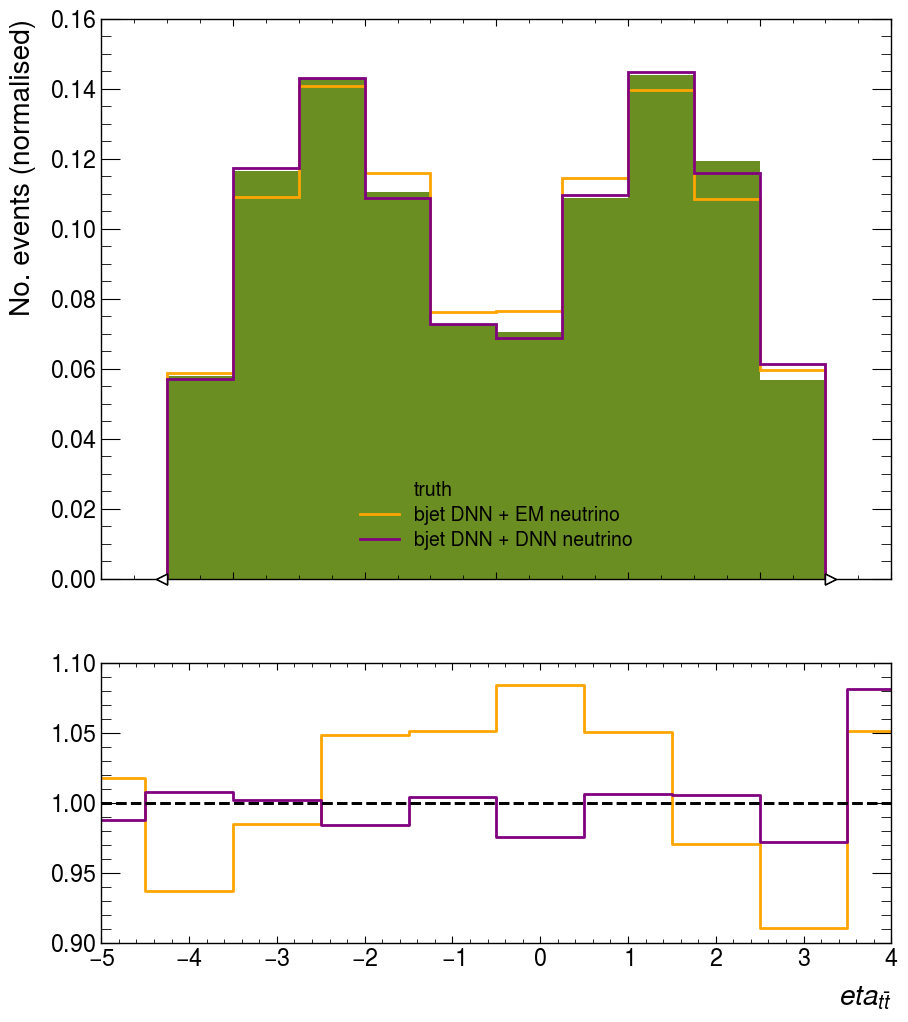

In [390]:
#invariant mas not looking right for reconstructed

def originalplotter(data1,data2,data3,label1,label2,label3,title,x_axis_label,y_axis_label,bins,xmin,xmax,data4,label4,save,data5,label5):
    # Use the ATLAS style for the plot
    hep.style.use(hep.style.ATLAS)

    # Create histograms with the specified bins
    hist1 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax))  
    hist2 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax)) 
    hist3 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax)) 
    hist4 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax))
    hist5 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax))

  

    # Fill the histograms with the data
    hist1.fill(data1) 
    hist2.fill(data2)  
    hist3.fill(data3)
    hist4.fill(data4)
    hist5.fill(data5)
    
    hist1 /= hist1.sum()
    hist2 /= hist2.sum()
    hist3 /= hist3.sum()
    hist4 /= hist4.sum()
    hist5 /= hist5.sum()


    # Plot the histograms
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 2]}, figsize=(10, 12))

    # Main plot
    hep.histplot(hist1, label=label1, ax=ax1, color = "olivedrab", lw=2, histtype="fill"  )
    hep.histplot(hist2, label=label2, ax=ax1, color = "orange", lw=2, linestyle = "-")
    hep.histplot(hist3, label=label3, ax=ax1, color = "purple", lw=2, linestyle="-")
    # hep.histplot(hist4, label=label4, ax=ax1, color = "red", lw=2, linestyle="-")
    # hep.histplot(hist5, label=label5, ax=ax1, color = "purple", lw=2, linestyle="-")
    ax1.set_xlabel("")
    ax1.set_ylabel(y_axis_label)
    ax1.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
    ax1.legend()

    # Calculate the ratio/residuals
    ratio1 = hist2.view() / hist1.view()
    ratio2 = hist3.view() / hist1.view()
    ratio3 = hist4.view() / hist1.view()
    ratio4 = hist5.view() / hist1.view()



    # Plot the ratio/residuals
    edges = hist1.axes[0].edges

    ax2.step(edges[:-1], ratio1, where='mid', color = "orange", lw=2)
    ax2.step(edges[:-1], ratio2, where='mid', color = "purple", lw=2, alpha=1)
    # ax2.step(edges[:-1], ratio3, where='mid', color = "red", lw=2, alpha=1)
    # ax2.step(edges[:-1], ratio4, where='mid', color = "purple", lw=2, alpha=1)
    ax2.step(edges[:-1], np.ones((bins,2)), where='mid', color = "black", linestyle="--")
    ax2.set_xlabel(x_axis_label)
    ax2.legend()


    if save is True:
        plt.savefig(f"newplots/{title}.png", dpi=500)
        plt.show()
    
data1=(truth_ttbar).eta
data2=(results_EM_ttbar).eta
data3=(combined_results_ttbar).eta
data4=(nu_NW_ttbar).eta
data5=(nu_DNN_ttbar).eta


label1 = "truth"
label2 = "bjet DNN + EM neutrino"
label3 = "bjet DNN + DNN neutrino"
label4 = "NW"
label5 = "DNN"

title = "ttbar eta COMBINED"
x_axis_label = r'$eta_{t\bar{t}}$'
y_axis_label = "No. events (normalised)"
bins=10
xmin=-5
xmax=5
save=True
originalplotter(data1,data2,data3,label1,label2,label3,title,x_axis_label,y_axis_label,bins,xmin,xmax,data4,label4,save,data5,label5)

In [ ]:
#plot graphs for truth and recon ttbar kinematics


def differenceplotter(data1,data2,data3,label1,label2,label3,title,x_axis_label,y_axis_label,bins,xmin,xmax,save):
    # Use the ATLAS style for the plot
    hep.style.use(hep.style.ATLAS)

    # Create histograms with the specified bins
    hist1 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax))  
    hist2 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax)) 
    hist3 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax)) 
    hist4 = bh.Histogram(bh.axis.Regular(bins, xmin, xmax)) 

    # Fill the histograms with the data
    hist1.fill(data1) 
    hist2.fill(data2)  
    hist3.fill(data3)
    hist4.fill(data4)

    # Main plot
    hep.histplot(hist1, label=label1, color = "blue", lw=1, linestyle = "-", yerr=0)
    hep.histplot(hist2, label=label2, color = "orange", lw=1, linestyle="-", yerr=0)
    hep.histplot(hist3, label=label3, color = "green", lw=1, linestyle="-", yerr=0)
    hep.histplot(hist4, label=label4, color = "red", lw=1, linestyle="-", yerr=0)

    plt.ylabel(y_axis_label)
    plt.legend()
    
    plt.xlabel(x_axis_label)
    if save is True:
        plt.savefig(f"newplots/{title}.png", dpi=500)
    plt.show()
    
data1=(truth_ttbar).M-(results_sq_ttbar).M
data2=(truth_ttbar).M-(results_EM_ttbar).M
data3=(truth_ttbar).M-(results_SN_ttbar).M
data4=(truth_ttbar).M-(results_NW_ttbar).M

label1 = r'${\mu}^2$'
label2 = "EM"
label3 = "SN"
label4 = "NW"

title = "with DNN and different neutrinos ttbar M"
x_axis_label = r'${\Delta}M_{t{\bar{t}}}/GeV$'
y_axis_label = "No. events (normalised)"
bins=25
xmin=-300
xmax=300
save=True
differenceplotter(data1,data2,data3,label1,label2,label3,title,x_axis_label,y_axis_label,bins,xmin,xmax,save)

In [ ]:
nu_truth = vector.zip({'pt': tree["nu_pt"].array(), 'eta': tree["nu_eta"].array(), 'phi': tree["nu_phi"].array(), 'm': tree["nu_mass"].array()})[match_correct_truth_events_mask]
nubar_truth = vector.zip({'pt': tree["nubar_pt"].array(), 'eta': tree["nubar_eta"].array(), 'phi': tree["nubar_phi"].array(), 'm': tree["nubar_mass"].array()})[match_correct_truth_events_mask]
